In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
import skimage
from tabulate import tabulate
from skimage.filters import frangi
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

SAVE_PLOTS = True
PATH = "./image_processing"
if SAVE_PLOTS and not os.path.exists(PATH):
    os.mkdir(PATH)

IMAGE = './CHASEDB1/Image_01L.jpg'

# Mandatory requirements

In [24]:
img = cv2.imread(IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

RESULTS = []

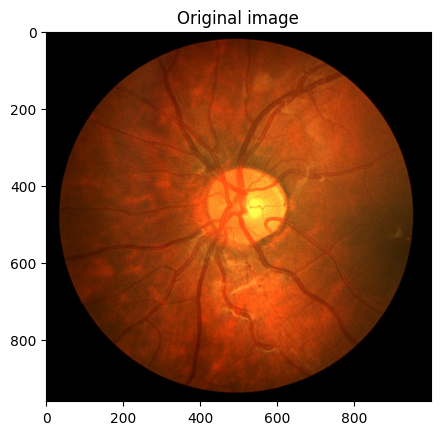

In [25]:
plt.title('Original image')
plt.imshow(img)

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/original_image.png')

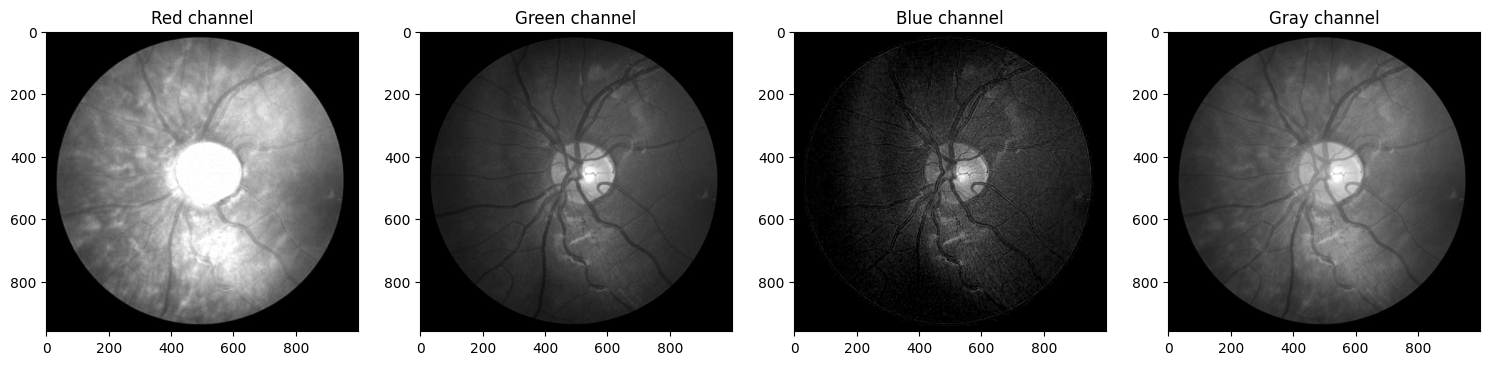

In [26]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

ax[0].set_title('Red channel')
ax[0].imshow(img[:, :, 0], cmap='gray')

ax[1].set_title('Green channel')
ax[1].imshow(img[:, :, 1], cmap='gray')

ax[2].set_title('Blue channel')
ax[2].imshow(img[:, :, 2], cmap='gray')

ax[3].set_title('Gray channel')
ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/channels.png')

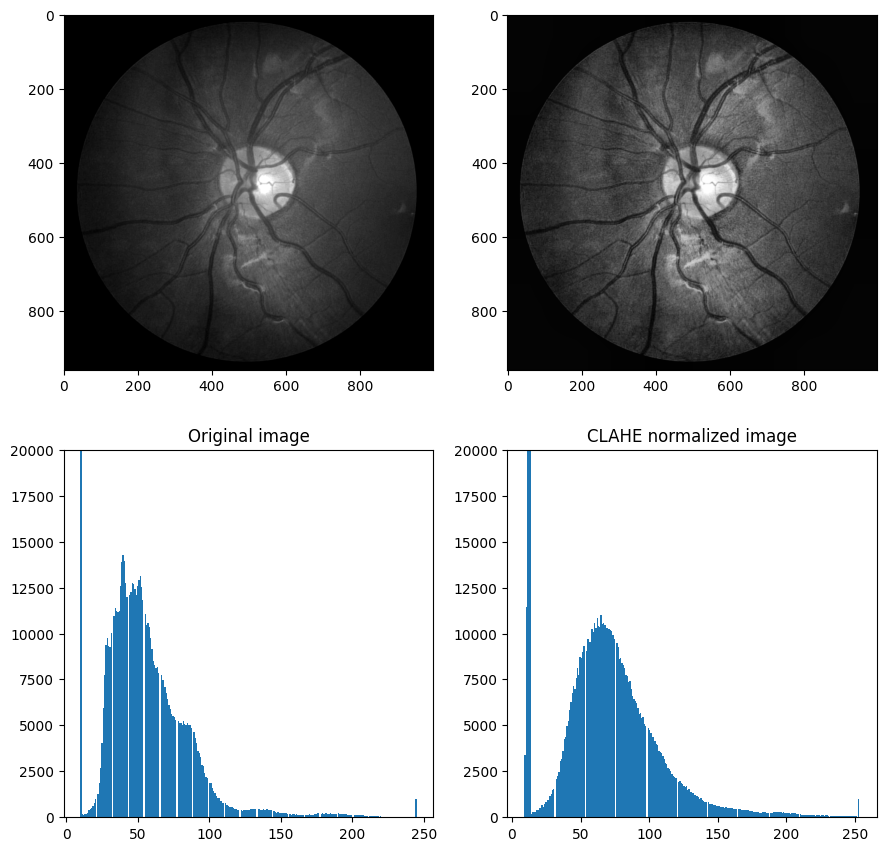

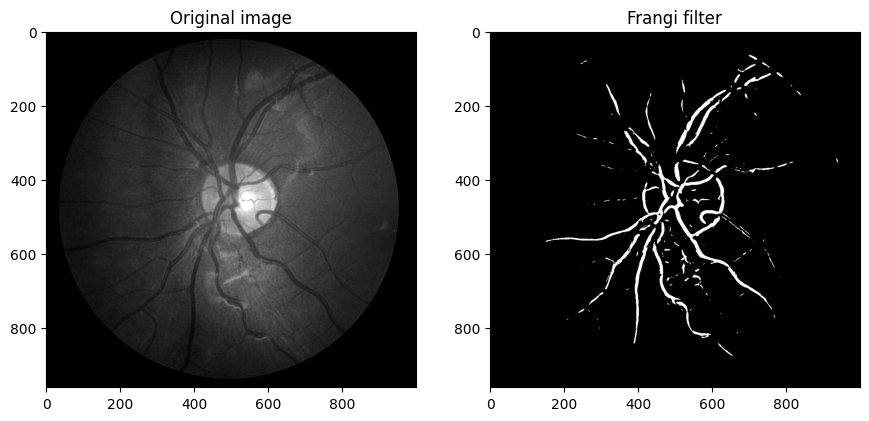

In [27]:
img_gray = img[:, :, 1]

img_gray = np.clip(img_gray, 10, 245)

# Parameters can be changed
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_gray_norm = clahe.apply(img_gray)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10.5, 10.5)

ax[0][0].imshow(img_gray, cmap='gray')
ax[0][1].imshow(img_gray_norm, cmap='gray')

ax[1][0].hist(img_gray.ravel(), bins=256)
ax[1][0].set_title('Original image')
ax[1][0].set_ylim([0, 20000])

ax[1][1].hist(img_gray_norm.ravel(), bins=256)
ax[1][1].set_title('CLAHE normalized image')
ax[1][1].set_ylim([0, 20000])

# Parameters can be changed
img_frangi = frangi(img_gray_norm, sigmas=np.arange(1, 5, 0.5), black_ridges=True)
img_frangi = img_frangi / img_frangi.max()
img_frangi = np.where(img_frangi > 0.065, 1, 0)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10.5, 10.5)

ax[0].set_title('Original image')
ax[0].imshow(img_gray, cmap='gray')

ax[1].set_title('Frangi filter')
ax[1].imshow(img_frangi, cmap='gray')

RESULTS.append(img_frangi)

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/frangi.png')

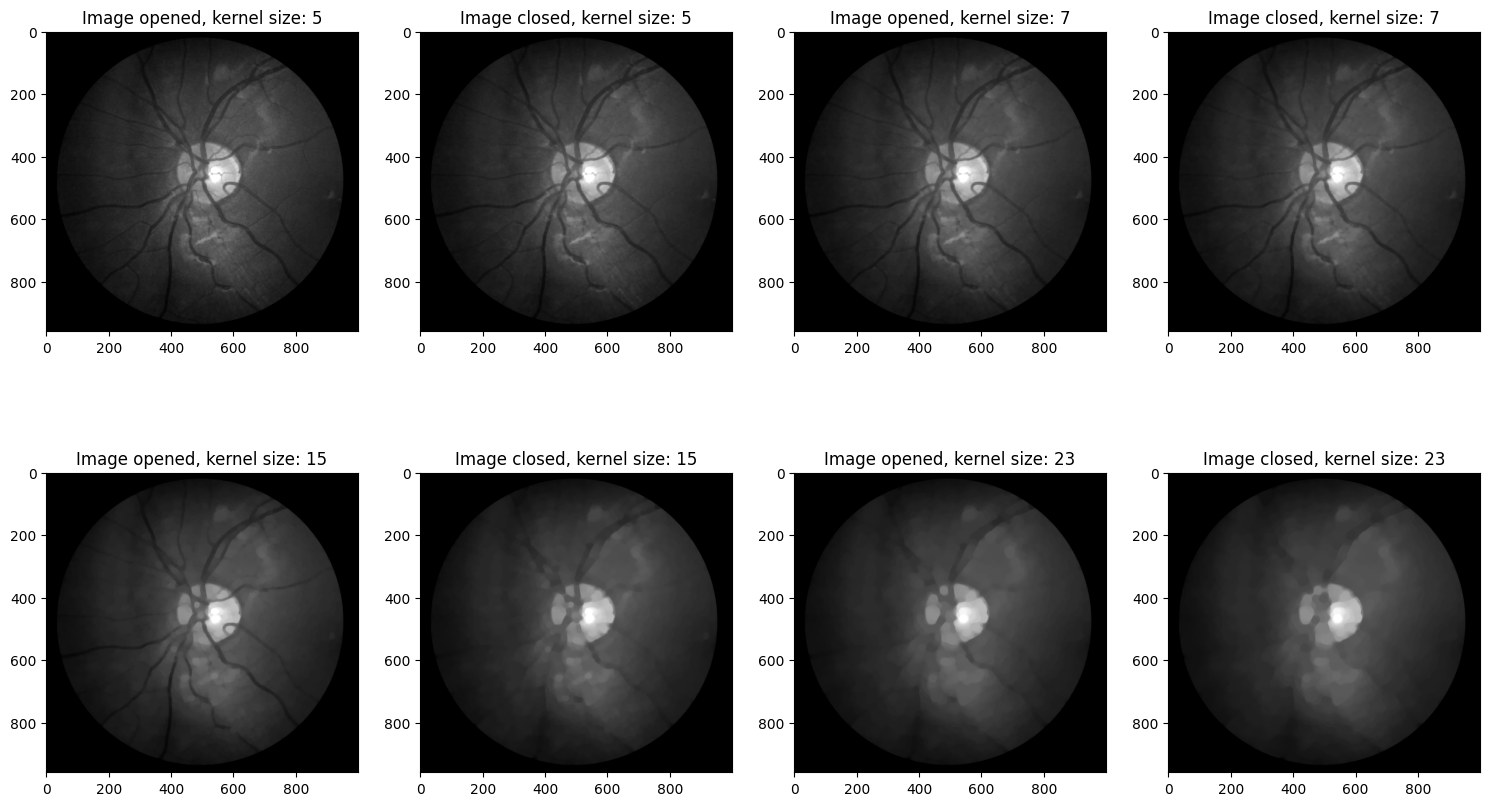

In [28]:
KERNEL_SIZES = [5, 7, 15, 23]
images = []
images.append(np.copy(img_gray))

for i in range(len(KERNEL_SIZES)):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (KERNEL_SIZES[i], KERNEL_SIZES[i]))

    new_img = cv2.morphologyEx(images[-1], cv2.MORPH_OPEN, kernel)
    images.append(np.copy(new_img))

    new_img = cv2.morphologyEx(images[-1], cv2.MORPH_CLOSE, kernel)
    images.append(np.copy(new_img))

images = images[1:]

fig, ax = plt.subplots(2, len(images) // 2)
fig.set_size_inches(18.5, 10.5)

n = len(images)
for i in range(n):
    ax[i // (n//2)][i % (n//2)].imshow(images[i], cmap='gray')
    if i % 2 == 0:
        ax[i // (n//2)][i % (n//2)].set_title('Image opened, kernel size: ' + str(KERNEL_SIZES[i // 2]))
    else:
        ax[i // (n//2)][i % (n//2)].set_title('Image closed, kernel size: ' + str(KERNEL_SIZES[i // 2]))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/morphological.png')

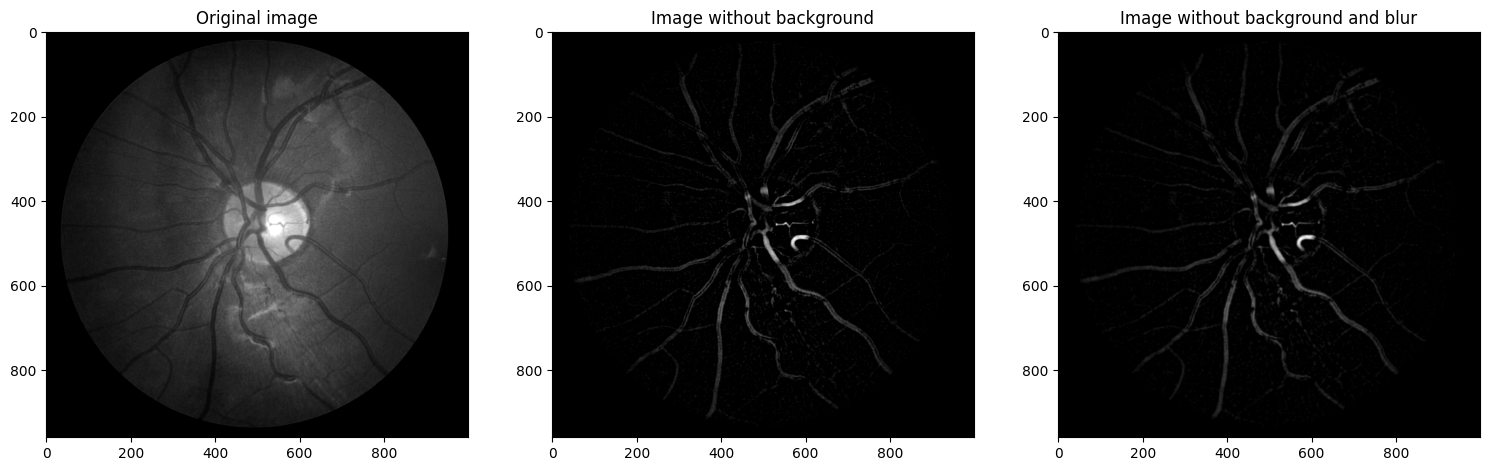

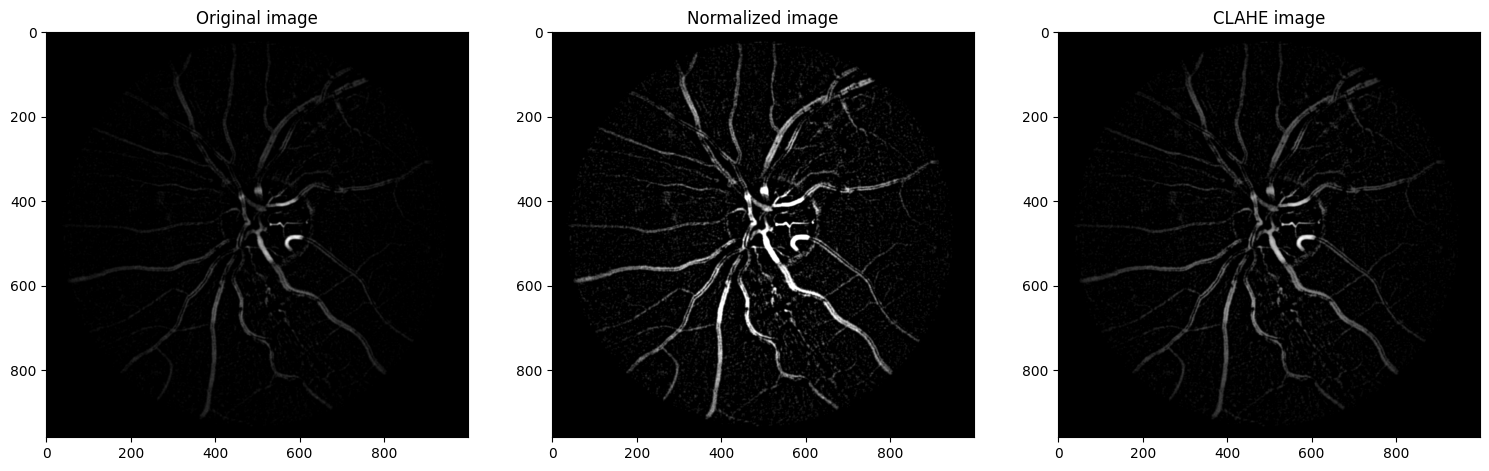

In [29]:
background = images[-1]
img_no_background = cv2.subtract(background, img_gray)
# img_no_background = img_gray_norm - background

img_no_background_blur = cv2.GaussianBlur(img_no_background, (5, 5), 0)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18.5, 18.5)

ax[0].set_title('Original image')
ax[0].imshow(img_gray, cmap='gray')

ax[1].set_title('Image without background')
ax[1].imshow(img_no_background, cmap='gray')

ax[2].set_title('Image without background and blur')
ax[2].imshow(img_no_background_blur, cmap='gray')

img_normalized_clip = np.clip(img_no_background_blur, 0, 20)
img_normalized = (img_normalized_clip / img_normalized_clip.max()) * 255

img_clahe = clahe.apply(img_no_background_blur)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18.5, 18.5)

ax[0].set_title('Original image')
ax[0].imshow(img_no_background_blur, cmap='gray')

ax[1].set_title('Normalized image')
ax[1].imshow(img_normalized, cmap='gray')

ax[2].set_title('CLAHE image')
ax[2].imshow(img_clahe, cmap='gray')

RESULTS.append(img_normalized)
RESULTS.append(img_clahe)

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/background.png')

| Method                         |   Accuracy |   Sensitivity |   Specificity |
|:-------------------------------|-----------:|--------------:|--------------:|
| Frangi                         |       0.95 |          0.37 |          0.82 |
| Background removal + rescaling |       0.94 |          0.1  |          0.9  |
| Background removal + CLAHE     |       0.93 |          0.01 |          0.97 |


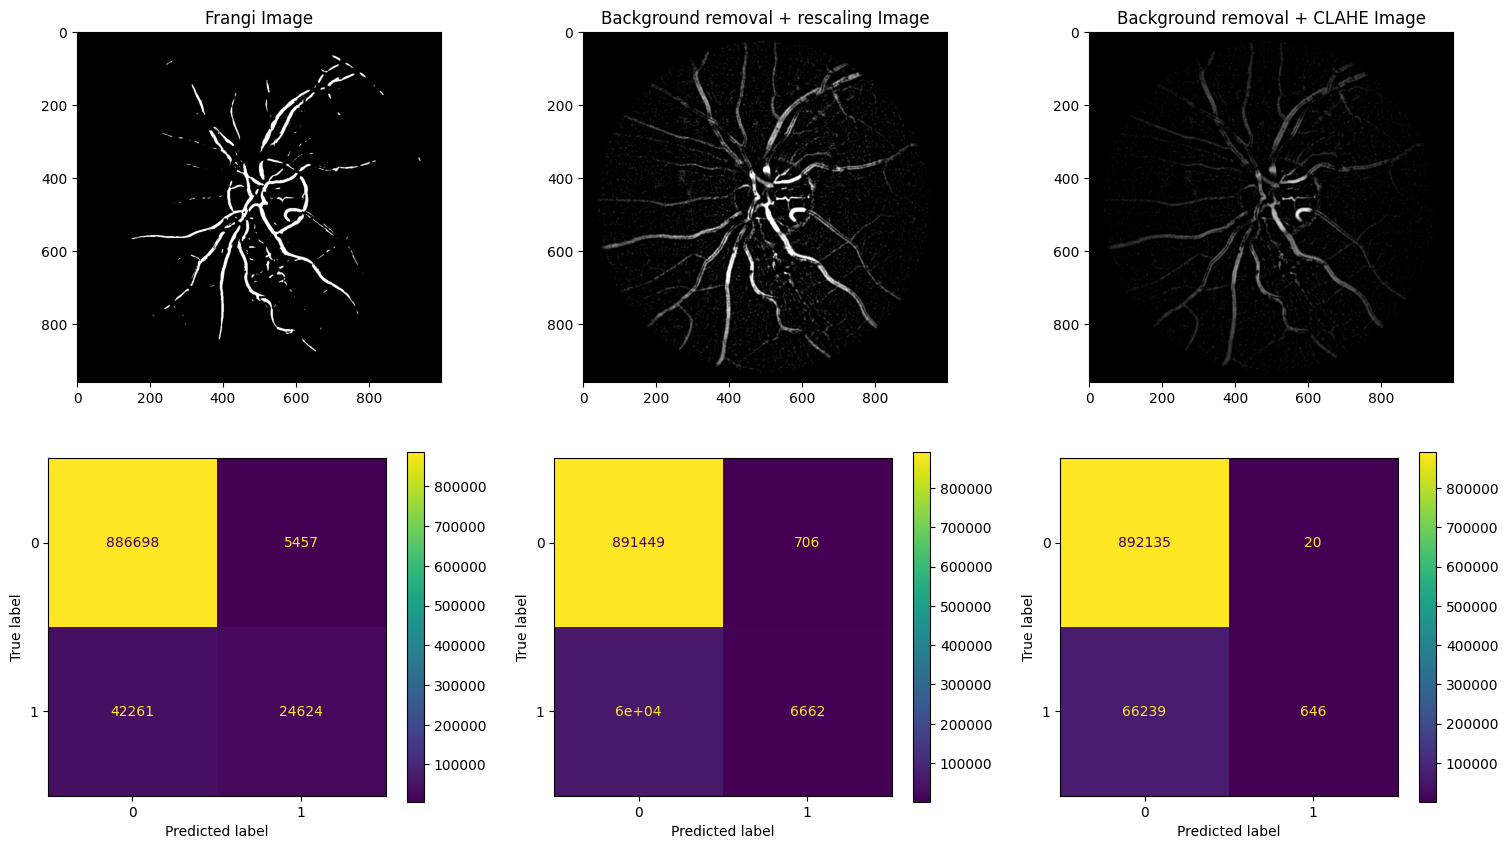

In [30]:
img_true = cv2.imread('./CHASEDB1/Image_01L_1stHO.png')
img_true_greyscale = cv2.cvtColor(img_true, cv2.COLOR_RGB2GRAY)

y_true = img_true_greyscale.ravel()
y_true = y_true / y_true.max()

fig, axs = plt.subplots(2, len(RESULTS)) 
fig.set_size_inches(18.5, 10)

headers = ["Method", "Accuracy", "Sensitivity", "Specificity"]
data = []

for img_pred, method, i in zip(RESULTS,
                               ['Frangi',
                                'Background removal + rescaling',
                                'Background removal + CLAHE'],
                                range(len(RESULTS))):
    
    y_pred = img_pred.ravel()
    y_pred = y_pred / y_pred.max()

    y_true_binary = np.where(y_true > 0.75, 1, 0)
    y_pred_binary = np.where(y_pred > 0.75, 1, 0)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    axs[0][i].imshow(img_pred, cmap='gray')
    axs[0][i].set_title(f"{method} Image")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[1][i])

    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)

    data.append([method, f"{accuracy:.2f}", f"{recall:.2f}", f"{precision:.2f}"])

print(tabulate(data, headers=headers, tablefmt="pipe"))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/results.png')